In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import anndata as ad
import sys
import bbknn
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import harmonypy as hm

import celltypist
from celltypist import models

import muon as mu
from muon import MuData

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [2]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/download_object/CellTypist_Tcell_Thymus_Blood_Reference_v2_count.h5ad'
adata_T = sc.read_h5ad(input_file)

In [3]:
adata_T.obs

,Harmonised_broad_type,Harmonised_detailed_type,Label_from_original_study,Tissue,Dataset,Protocol,Iteration
FCAImmP7179369-AACTTTCCAAGTTAAG,T cells,CD8a/a,CD8αα(II),Thymus,Park et al. 2020,10X,1
FCAImmP7179369-AAGGCAGTCAAAGTAG,T cells,CD8a/a,CD8αα(I),Thymus,Park et al. 2020,10X,1
FCAImmP7179369-AATCCAGCAGCTTCGG,T cells,CD8a/a,CD8αα(I),Thymus,Park et al. 2020,10X,1
FCAImmP7179369-ACACCGGTCGAATGCT,T cells,CD8a/a,CD8αα(II),Thymus,Park et al. 2020,10X,1
FCAImmP7179369-ACACTGAAGCCCTAAT,T cells,CD8a/a,CD8αα(I),Thymus,Park et al. 2020,10X,1
...,...,...,...,...,...,...,...
CZINY-0063_CAGGGCTGTTTCGTTT,T cells,MAIT cells,MAIT,Blood,Dominguez Conde et al. 2022,10X,2
CZINY-0111_TCGAAGTGTGTCTTCC,T cells,MAIT cells,MAIT,Blood,Dominguez Conde et al. 2022,10X,2
CZINY-0064_CATTCCGTCTGCGGCA,T cells,MAIT cells,MAIT,Blood,Dominguez Conde et al. 2022,10X,2
CZINY-0064_TGATCTTCAGCTCATA,T cells,MAIT cells,MAIT,Blood,Dominguez Conde et al. 2022,10X,2


In [4]:
adata_T.obs['Tissue'].value_counts()

Thymus    153995
Blood      58798
Name: Tissue, dtype: int64

In [5]:
sc.pp.normalize_per_cell(adata_T, counts_per_cell_after = 1e4)
sc.pp.log1p(adata_T)

normalizing by total count per cell
    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [6]:
import random
random.seed(11)

adata_sub = sc.pp.subsample(adata_T, fraction=0.3, copy=True)
adata_sub.X.shape
adata_sub.obs['Harmonised_detailed_type'].value_counts()

In [7]:
adata_sub = adata_sub[~adata_sub.obs['Harmonised_detailed_type'].isin(['gamma-delta T cells'])]

In [8]:
#adata_sub.X = adata_sub.X.expm1()/100000
#sc.pp.normalize_total(adata_sub, target_sum=1e4)
#sc.pp.log1p(adata_sub)

In [9]:
adata_T.X.expm1().sum(axis = 1)

matrix([[10000.001],
        [10000.   ],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.001]], dtype=float32)

In [ ]:
new_model = celltypist.train(adata_T, labels = 'Harmonised_detailed_type', use_SGD = True, mini_batch = True)

🍳 Preparing data before training
✂️ 11218 non-expressed genes are filtered out
⚖️ Scaling input data


In [12]:
new_model.write('/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/download_object/CellTypist_Tcell_Thymus_Blood_Reference_v2_sub0.3_feature_selection.pkl')

In [2]:
new_model = models.Model.load('/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/download_object/CellTypist_Tcell_Thymus_Blood_Reference_v2_sub0.3_feature_selection.pkl')

In [3]:
new_model

CellTypist model with 23 cell types and 2550 features
    date: 2023-07-05 22:54:17.424630
    cell types: CD16+ NK cells, CD16- NK cells, ..., Type 17 helper T cells
    features: A1BG, A2M, ..., ZYX

In [9]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Subset_Tcell_final_soupX_processed_noBatchC_dandelion.1.h5ad'
adata = sc.read_h5ad(input_file)

In [10]:
adata = adata.raw.to_adata()
adata.X.expm1().sum(axis = 1)

matrix([[ 9999.999],
        [ 9999.999],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.001],
        [10000.002]], dtype=float32)

In [6]:
### remove TCR genes from HVG
adata.var['Keep'] = True
import re
for i in adata.var.index:
    if re.search('^TR[AB][VDJC]', i):
        adata.var.at[i, 'Keep'] = False

adata = adata[:, adata.var['Keep']]
adata.var

,gene_ids,n_cells,Keep
MIR1302-2HG,MIR1302-2HG,13,True
AL627309.1,AL627309.1,306,True
AL627309.3,AL627309.3,34,True
AL627309.5,AL627309.5,2082,True
AL627309.4,AL627309.4,5,True
...,...,...,...
AC136616.2,AC136616.2,66,True
AC141272.1,AC141272.1,109,True
AC007325.1,AC007325.1,5,True
AC007325.4,AC007325.4,104,True


In [11]:
predictions = celltypist.annotate(adata, model = new_model, majority_voting = True)

🔬 Input data has 123194 cells and 30472 genes
🔗 Matching reference genes in the model
🧬 2271 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25


running Leiden clustering
    finished: found 326 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:01:29)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [12]:
adata = predictions.to_adata()

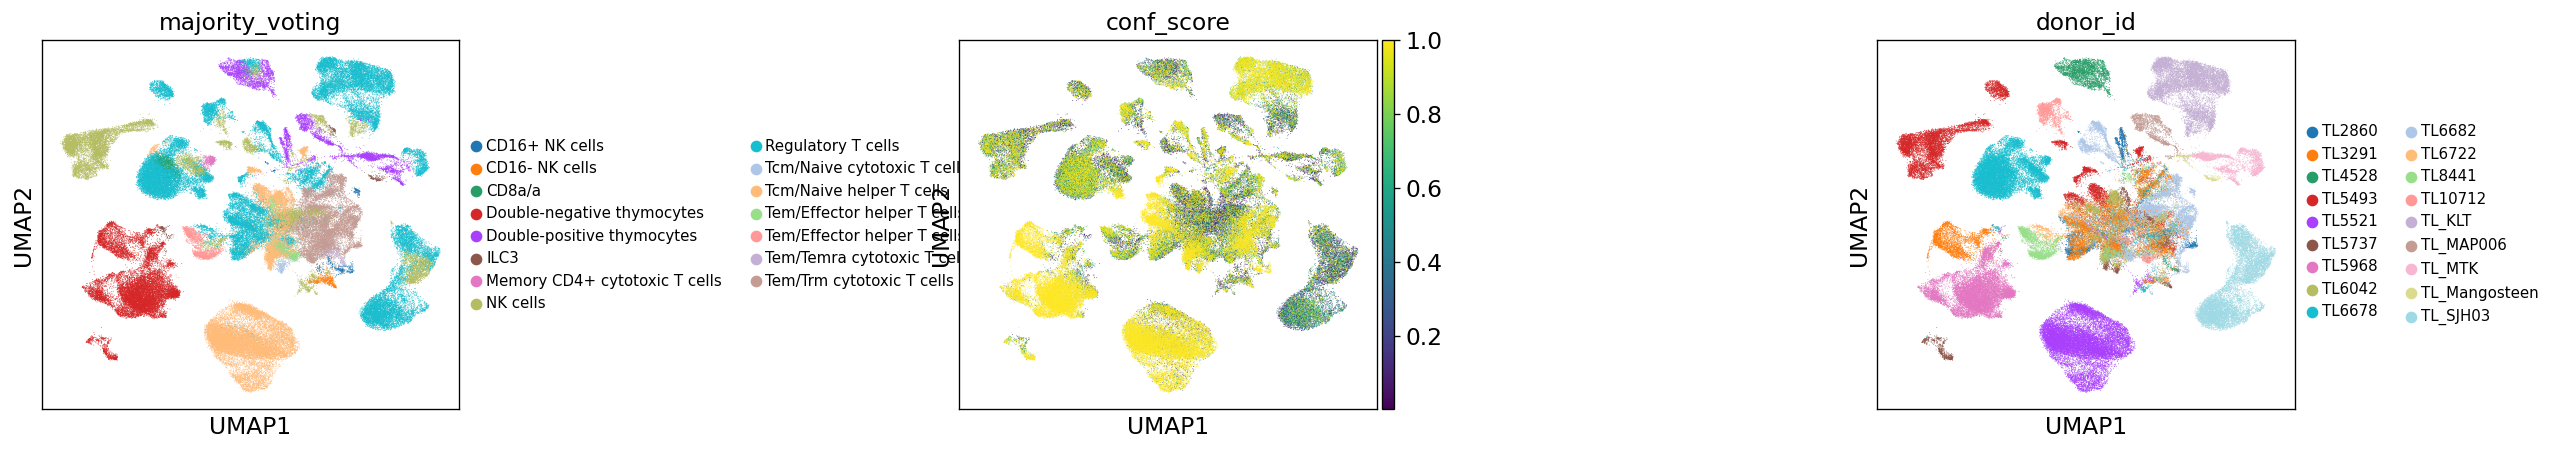

In [13]:
sc.settings.set_figure_params(dpi=60, facecolor='white')
sc.pl.umap(adata, color = ['majority_voting','conf_score', 'donor_id'], legend_fontsize=9, wspace = 1)

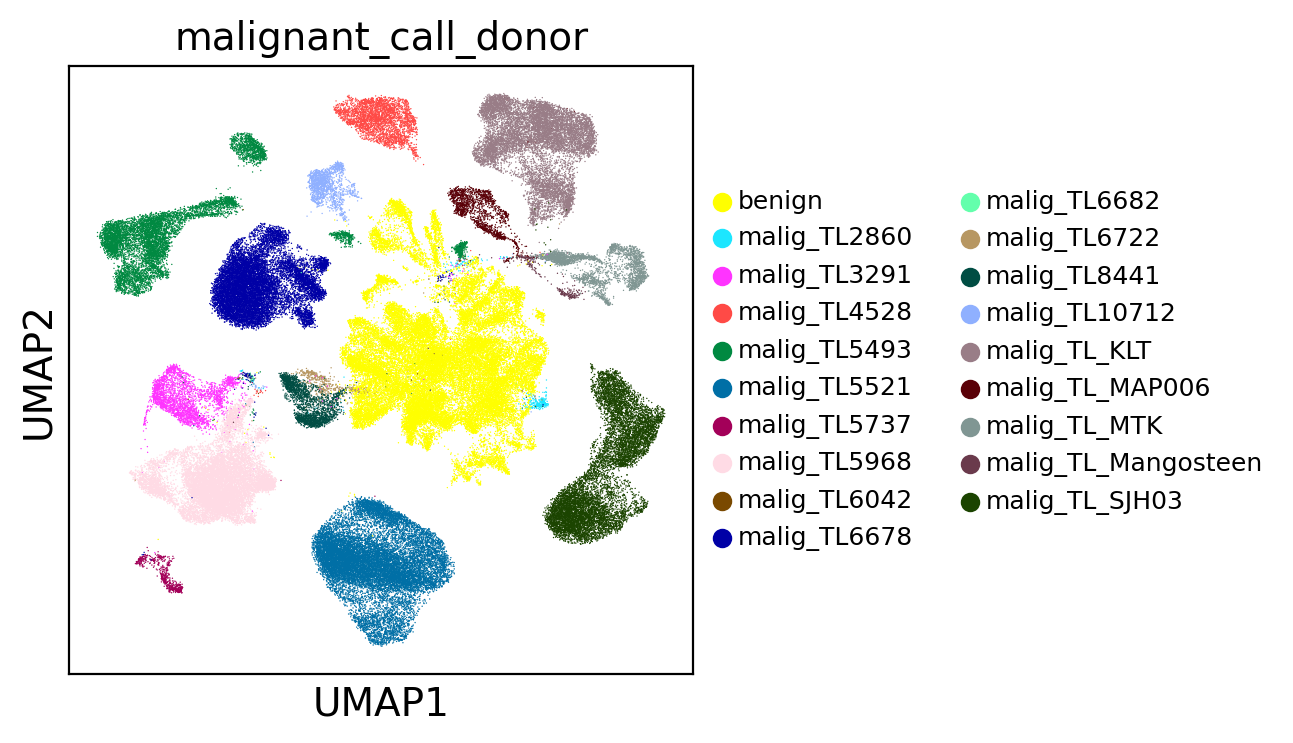

In [13]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata, color = ['malignant_call_donor'],legend_fontsize=9)

In [15]:
adata

AnnData object with n_obs × n_vars = 123194 × 30472
    obs: 'ID', 'sample_id', 'donor_id', 'tumour_type', 'age', 'site', 'type', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_0.8', 'leiden_1.0', 'leiden_1.0_c14', 'leiden_1.0_c14_C15', 'broad_cell_type', 'leiden_0.8_c22', 'leiden_0.8_c22_c3', 'malignant_call', 'malignant_call_donor', 'malignant_call_tumour_type', 'has_contig', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main',

In [16]:
categories_order = [
                    'malig_TL10712','malig_TL_MTK','malig_TL_Mangosteen','malig_TL_MAP006','malig_TL_KLT','malig_TL_SJH03',
                    'malig_TL5493','malig_TL6678','malig_TL6722',
                    'malig_TL4528','malig_TL8441','malig_TL3291','malig_TL5737','malig_TL5968','malig_TL5521','malig_TL2860',
                    'benign']

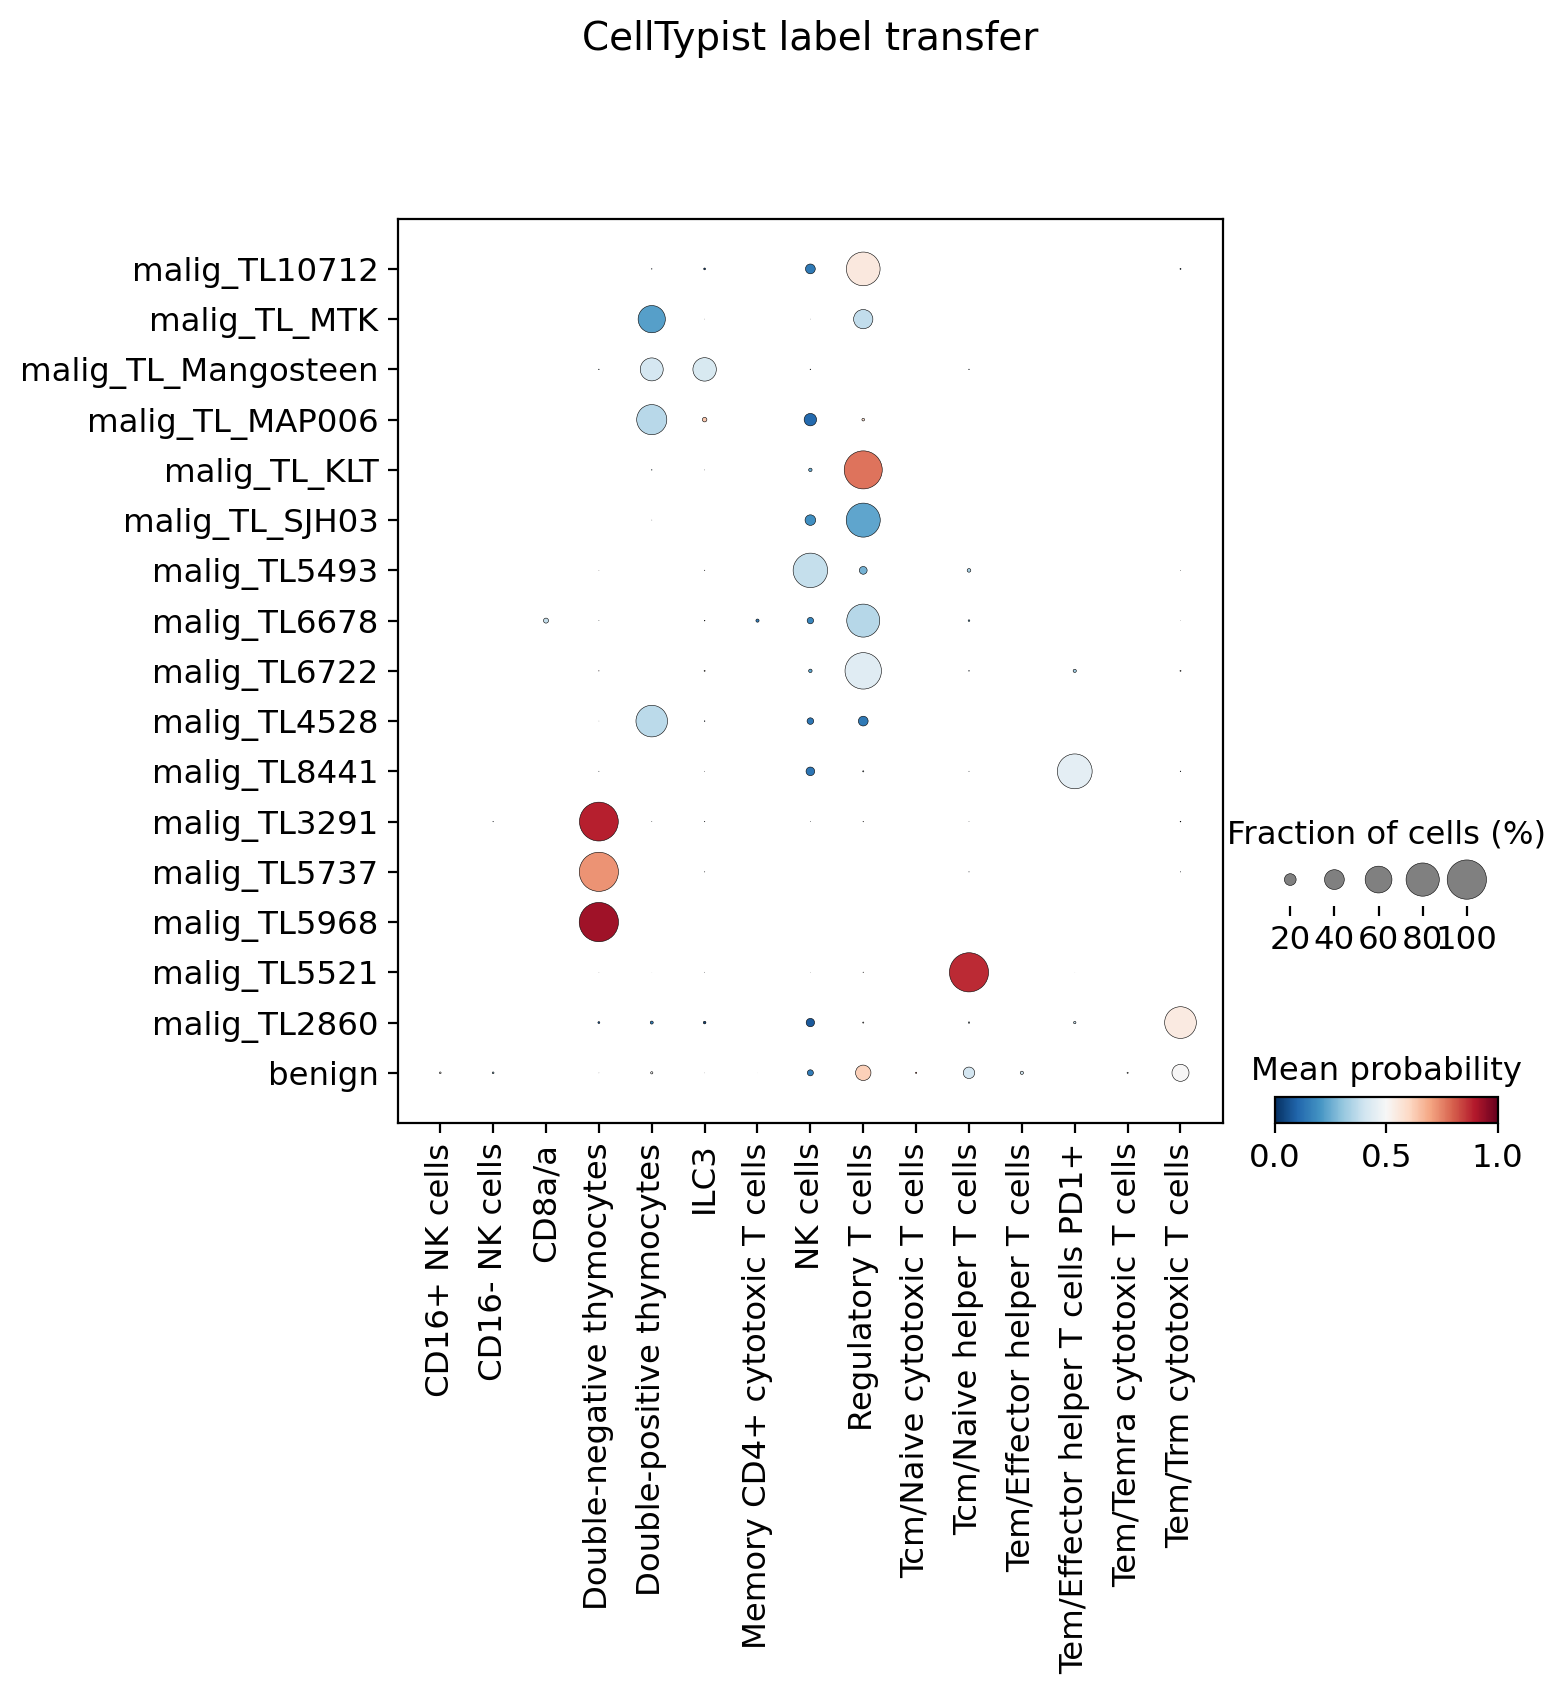

In [17]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
dp = celltypist.dotplot(predictions, use_as_reference = 'malignant_call_donor', use_as_prediction = 'majority_voting',
                        swap_axes=True, reference_order = categories_order)

In [18]:
new_model.extract_top_markers('Double-positive thymocytes', 50)

array(['SMPD3', 'SH3TC1', 'AEBP1', 'CD1E', 'CD1B', 'ELOVL4', 'CD8B',
       'CD52', 'AQP3', 'RAG2', 'SLC29A1', 'CYCS', 'TCF7', 'LYST', 'RORC',
       'ARPP21', 'P2RX5', 'EPHX2', 'LY6E', 'TRBC2', 'RP11-144L1.4', 'CD4',
       'MCM5', 'CD38', 'HPGDS', 'RAG1', 'WDR34', 'PRDX2', 'NDUFV1',
       'NPPC', 'CYP2U1', 'CALN1', 'VOPP1', 'DPF3', 'CD1A', 'SLA', 'ANXA1',
       'CHEK1', 'RP11-620J15.3', 'NBEAL1', 'C12orf57', 'C12orf75',
       'NAT14', 'H2AFV', 'IL32', 'REC8', 'TFDP2', 'CHRNA3', 'PA2G4',
       'HNRNPC'], dtype=object)

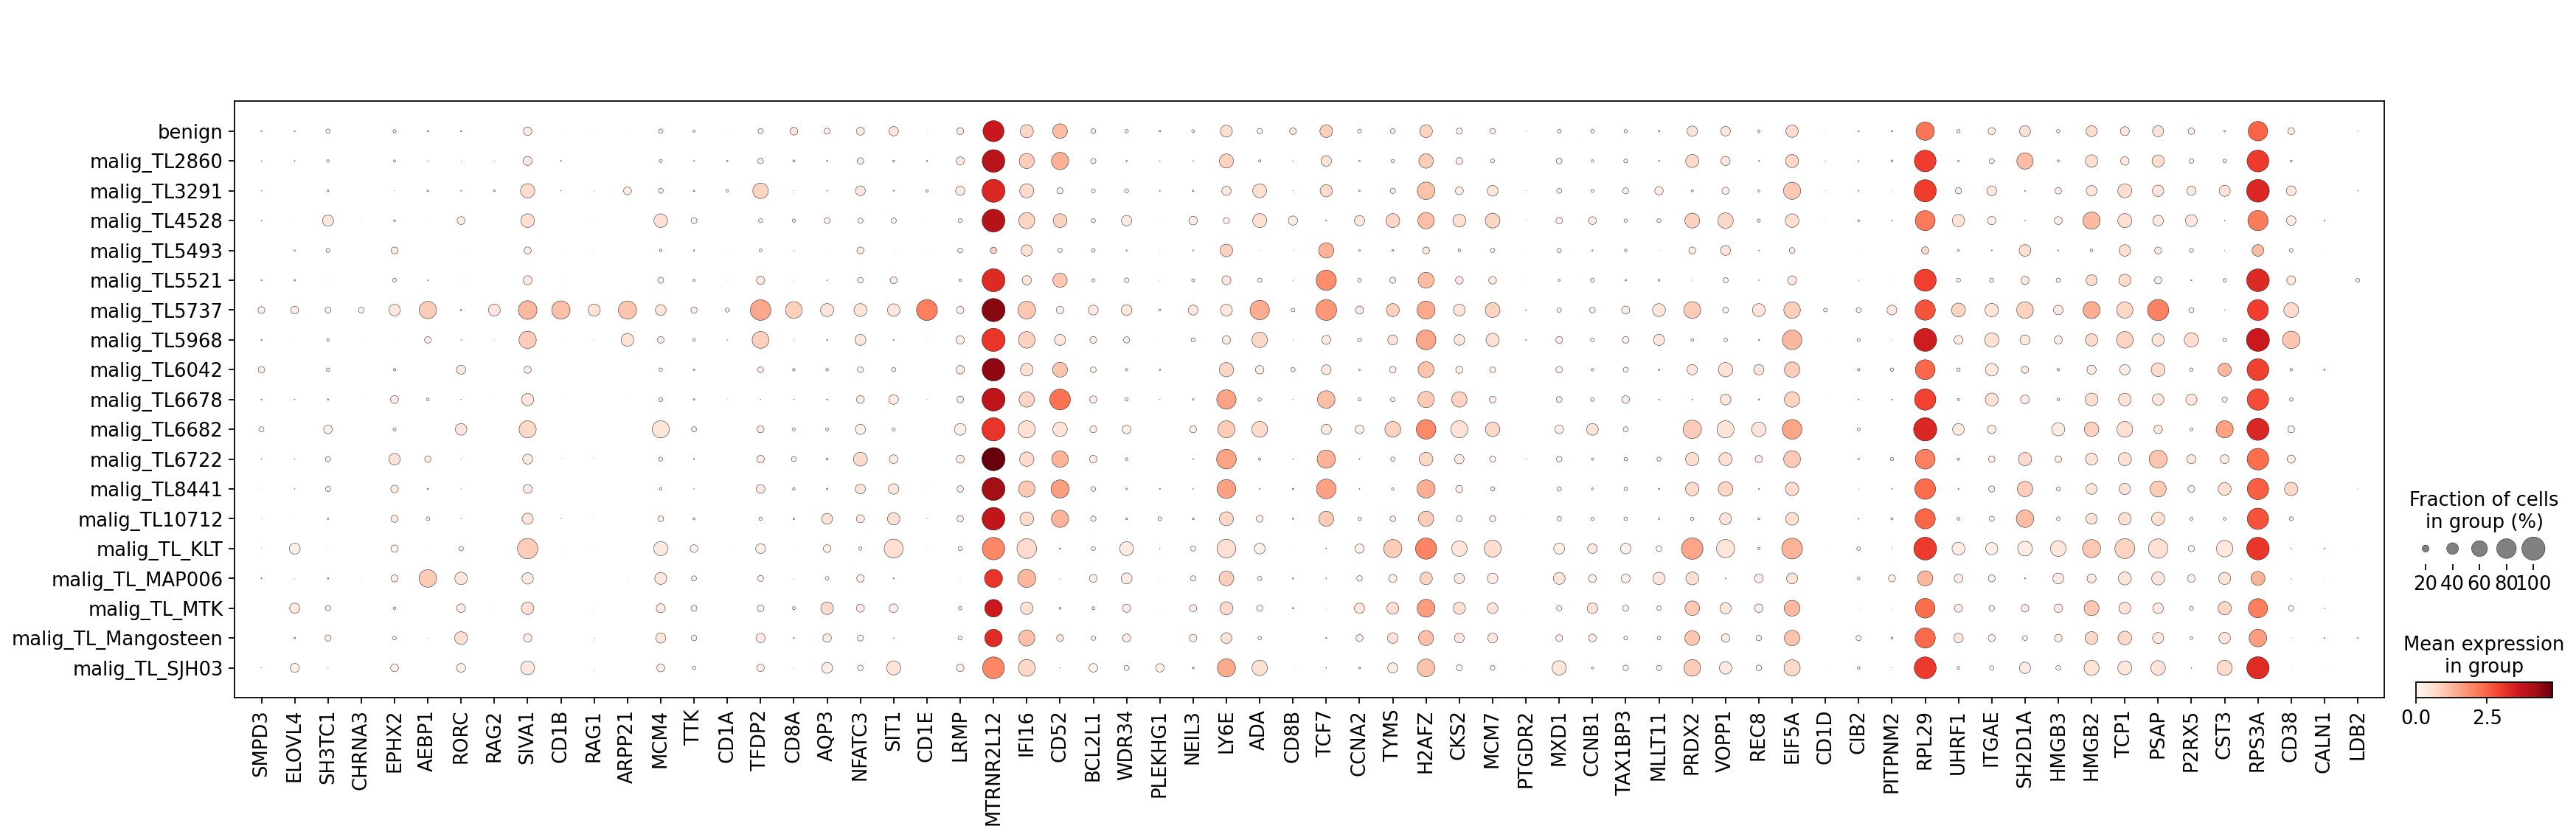

In [67]:
genes = new_model.extract_top_markers('Double-positive thymocytes', 70)
genes = np.delete(genes, [18,39,44,49,50,53])

sc.settings.set_figure_params(dpi=80)
dp = sc.pl.dotplot(adata,
                   genes, groupby='malignant_call_donor',dendrogram=False, color_map='Reds')